In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

%matplotlib inline

#### Read in the data

In [5]:
beer = pd.read_csv('/data/beer/train.csv')
beer_test = pd.read_csv('/data/beer/test.csv')

In [186]:
brendan = [3,4,12,12,2,3,8]
np.power(brendan,2)
#np.log(brendan)

#np.log(np.log(beer['review/overall']))

array([  9,  16, 144, 144,   4,   9,  64])

In [214]:
## formula for linear regression
def lm(y_var, x_vars, data):    
    """Fits linear regression to predict y_var from x_vars.
    
    Args:
      - y_var: A string represent the name of the column to use as the response variable.
      - x_vars: A list of strings representing the names of the columns to use as predictors.
      - data: A Pandas data frame.
      
    Returns:
      - A Pandas Series that stores the variable names and the associated coefficients.
    """
    ## create column of 1s and add to our data
    D = data[x_vars].copy()
    D["Intercept"] = 1
    #y = np.power(data[y_var],2)
    y = data[y_var]
    
    ## Method 1: explicit inverse
    #inverse = np.linalg.inv(np.dot(D.T,D))
    #coefs = np.dot(inverse,np.dot(D.T,y))
    #return coefs

    ## Method 2: 
    V = np.dot(D.T,D)
    W = np.dot(D.T,y)
    coefs = np.linalg.solve(V,W)
    return pd.Series(dict(zip(D.columns,coefs)))

## let's make some variables

#### function for the styles of beer

In [6]:
def style_func(df):
    """ Test Function for generating new value"""
    if "Pale Ale" in df["beer/style"]:
        return "paleale"
    elif "Ale" in df["beer/style"]:
        return "ale"
    elif "Stout" in df["beer/style"]:
        return "stout"
    elif "Pilsener" in df["beer/style"] or "Pilsner" in df["beer/style"]:
        return "pilsner"
    elif "Lager" in df["beer/style"]:
        return "lager"
    else:
        return "other"
    
beer["style"] = beer.apply(style_func, axis=1)

#### adding dummy variables for style and gender

In [8]:
s = pd.get_dummies(beer['style'])
del s['other']
gender = pd.get_dummies(beer['user/gender'])
beer = pd.concat([beer,s],axis = 1)
beer = pd.concat([beer,gender],axis = 1)

#### adding dummy variable for popular brewery

In [44]:
cts = beer['beer/brewerId'].value_counts()

In [97]:
popularBrewery = np.array([])

for i in range(len(beer)):
    if (cts.get(beer['beer/brewerId'][i]) > 10):
        popularBrewery = np.append(popularBrewery,1)
    else:
        popularBrewery = np.append(popularBrewery,0)
popularBrewery = pd.DataFrame(popularBrewery,columns = ['popularBrewery'])
beer = pd.concat([beer,popularBrewery],axis = 1)

### SENTIMENT ANALYSIS

In [9]:
from textblob import TextBlob

def calc_sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

beer['text/sentiment'] = beer['review/text'].apply(calc_sentiment)

In [10]:
def set_polarity(tuples):
    try:
        return tuples[0]
    except:
        return None

def set_objectivity(tuples):
    try:
        return tuples[1]
    except:
        return None
    
beer['sentiment/polarity'] = beer['text/sentiment'].apply(set_polarity)

beer['sentiment/objectivity'] = beer['text/sentiment'].apply(set_objectivity)

#### changing the age variable to be by years and creating the dummies

In [14]:
beer['user/ageInYears'] = beer['user/ageInSeconds'] / 60 / 60 / 24 / 365.25
bins = [20,35,50,65,80,120]
group_names = ['20-35','35-50','50-65','65-80','over 80']
bday_groups = pd.cut(beer['user/ageInYears'],bins,labels = group_names)
b = pd.get_dummies(bday_groups)
beer =  pd.concat([beer,b],axis = 1)

#### creating the length of review

In [11]:
def get_review_length(text):
    try:
        return len(TextBlob(text).words)
    except:
        return 0
beer['review/wordLength'] = beer['review/text'].apply(get_review_length)

### Interaction Variables Son!!

In [12]:
beer['ABVxFemale'] = beer['beer/ABV'] * beer['Female']
beer['ABVxMale'] = beer['beer/ABV'] * beer['Male']
beer['ABVxAle'] = beer['beer/ABV'] * beer['ale']
beer['ABVxLager'] = beer['beer/ABV'] * beer['lager']
beer['ABVxPaleAle'] = beer['beer/ABV'] * beer['paleale']
beer['ABVxPilsner'] = beer['beer/ABV'] * beer['pilsner']
beer['ABVxStout'] = beer['beer/ABV'] * beer['stout']
beer['LengthxPolarity'] = beer['sentiment/polarity'] * beer['review/wordLength']

In [113]:
beer['popularxLength'] = beer['popularBrewery'] * beer['review/wordLength']
beer['popularxAle'] = beer['popularBrewery'] * beer['ale']
beer['popularxLager'] = beer['popularBrewery'] * beer['lager']
beer['popularxPaleAle'] = beer['popularBrewery'] * beer['paleale']
beer['popularxPilsner'] = beer['popularBrewery'] * beer['pilsner']
beer['popularxStout'] = beer['popularBrewery'] * beer['stout']

In [124]:
beer = beer[beer['sentiment/polarity'].isnull() != True]

### Making Variables for the Testing Dataset

In [85]:
beer_test = pd.read_csv('/data/beer/test.csv')

gender = pd.get_dummies(beer_test['user/gender'])
beer_test["style"] = beer_test.apply(style_func, axis=1)
s = pd.get_dummies(beer_test['style'])
del s['other']
beer_test = pd.concat([beer_test,s],axis = 1)
beer_test = pd.concat([beer_test,gender],axis = 1)

beer_test['user/ageInYears'] = beer_test['user/ageInSeconds'] / 60 / 60 / 24 / 365.25
bday_groups = pd.cut(beer_test['user/ageInYears'],bins,labels = group_names)
b = pd.get_dummies(bday_groups)
beer_test =  pd.concat([beer_test,b],axis = 1)

beer_test['text/sentiment'] = beer_test['review/text'].apply(calc_sentiment)
beer_test['sentiment/polarity'] = beer_test['text/sentiment'].apply(set_polarity)
beer_test['sentiment/objectivity'] = beer_test['text/sentiment'].apply(set_objectivity)

beer_test['ABVxFemale'] = beer_test['beer/ABV'] * beer_test['Female']
beer_test['ABVxMale'] = beer_test['beer/ABV'] * beer_test['Male']
beer_test['ABVxAle'] = beer_test['beer/ABV'] * beer_test['ale']
beer_test['ABVxLager'] = beer_test['beer/ABV'] * beer_test['lager']
beer_test['ABVxPaleAle'] = beer_test['beer/ABV'] * beer_test['paleale']
beer_test['ABVxPilsner'] = beer_test['beer/ABV'] * beer_test['pilsner']
beer_test['ABVxStout'] = beer_test['beer/ABV'] * beer_test['stout']
beer_test['review/wordLength'] = beer_test['review/text'].apply(get_review_length)
beer_test['LengthxPolarity'] = beer_test['sentiment/polarity'] * beer_test['review/wordLength']

In [88]:
popularBrewery = np.array([])
for i in range(len(beer_test)):
    try:
        if (cts.get(beer_test['beer/brewerId'][i]) > 10):
            popularBrewery = np.append(popularBrewery,1)
        else:
            popularBrewery = np.append(popularBrewery,0)
    except:
        popularBrewery = np.append(popularBrewery,0)
popularBrewery = pd.DataFrame(popularBrewery,columns = ['popularBrewery'])
beer_test = pd.concat([beer_test,popularBrewery],axis = 1)

In [101]:
beer_test['popularxLength'] = beer_test['popularBrewery'] * beer_test['review/wordLength']
beer_test['popularxAle'] = beer_test['popularBrewery'] * beer_test['ale']
beer_test['popularxLager'] = beer_test['popularBrewery'] * beer_test['lager']
beer_test['popularxPaleAle'] = beer_test['popularBrewery'] * beer_test['paleale']
beer_test['popularxPilsner'] = beer_test['popularBrewery'] * beer_test['pilsner']
beer_test['popularxStout'] = beer_test['popularBrewery'] * beer_test['stout']

### Prediction Function

In [231]:
def predict(data,dictionary,column_name):
    data[column_name] = dictionary.get("Intercept")
    for key in dictionary.keys():
        if key != "Intercept":
            data[column_name] += dictionary.get(key) * data[key]
    avg = np.mean(data[column_name])
    data[column_name] = data[column_name].fillna(avg)
    data[column_name] = np.minimum(data[column_name],5)
    #data[column_name] = np.power(data[column_name],0.5)

In [230]:
hans = [2,3,4,5,6]
np.minimum(hans,5)

array([2, 3, 4, 5, 5])

### forwards stepwise regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model = LinearRegression()
y = beer["review/overall"]

vars_remaining = ['beer/ABV',
                 'Male','Female',
                 'sentiment/polarity',
                 'ale','lager','paleale','pilsner','stout',
                 'review/wordLength',
                 'ABVxMale','ABVxFemale',
                 'ABVxAle','ABVxLager','ABVxPaleAle','ABVxPilsner','ABVxStout']
vars_in_model = []
last_error = -np.inf

for _ in range(len(vars_remaining)):
    scores = []
    for var in vars_remaining:
        candidate_vars = vars_in_model + [var]
        X = beer[candidate_vars]
        scores.append(
            cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error").mean()
        )
    i = np.argmax(scores)
    if scores[i] <= last_error:
        break
    else:
        last_error = scores[i]
        var_to_add = vars_remaining[i]
        vars_in_model.append(var_to_add)
        del vars_remaining[i]

print (vars_in_model)

### BACKWARDS STEPWISE REGRESSION

### For overall

In [125]:
import copy
model = LinearRegression()
y = beer["review/overall"]

vars_remaining = []
vars_in_model = ['beer/ABV',
                 'Male','Female',
                 'sentiment/polarity',
                 'ale','lager','paleale','pilsner','stout',
                 'review/wordLength',
                 '20-35','35-50','50-65','65-80','over 80',
                 'popularBrewery',
                 'ABVxMale','ABVxFemale',
                 'LengthxPolarity',
                 'popularxAle','popularxLager','popularxPaleAle','popularxPilsner','popularxStout',
                 'ABVxAle','ABVxLager','ABVxPaleAle','ABVxPilsner','ABVxStout']
last_error = cross_val_score(model, beer[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
for _ in range(len(vars_in_model)):
    scores = []
    for var in vars_in_model:
        candidate_vars = copy.copy(vars_in_model)
        candidate_vars.remove(var)
        X = beer[candidate_vars]
        scores.append(
            cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error").mean()
        )
    i = np.argmax(scores)
    if scores[i] <= last_error:
        break
    else:
        last_error = scores[i]
        del vars_in_model[i]
        #print (vars_in_model,last_error)
print (vars_in_model)

['beer/ABV', 'Male', 'Female', 'sentiment/polarity', 'ale', 'lager', 'paleale', 'pilsner', 'stout', 'review/wordLength', '20-35', '35-50', '50-65', '65-80', 'over 80', 'popularBrewery', 'ABVxMale', 'ABVxFemale', 'LengthxPolarity', 'popularxAle', 'popularxLager', 'popularxPaleAle', 'popularxStout', 'ABVxAle', 'ABVxLager', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout'] -0.381605114133
['beer/ABV', 'Male', 'Female', 'sentiment/polarity', 'ale', 'lager', 'paleale', 'stout', 'review/wordLength', '20-35', '35-50', '50-65', '65-80', 'over 80', 'popularBrewery', 'ABVxMale', 'ABVxFemale', 'LengthxPolarity', 'popularxAle', 'popularxLager', 'popularxPaleAle', 'popularxStout', 'ABVxAle', 'ABVxLager', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout'] -0.381573674675
['beer/ABV', 'Male', 'Female', 'sentiment/polarity', 'ale', 'lager', 'stout', 'review/wordLength', '20-35', '35-50', '50-65', '65-80', 'over 80', 'popularBrewery', 'ABVxMale', 'ABVxFemale', 'LengthxPolarity', 'popularxAle', 'popularxLager', 'popul

In [232]:
results_overall = lm("review/overall",
                     ['beer/ABV',
                     'Female', 
                     'sentiment/polarity',
                     'ale', 'lager', 'paleale', 'stout','pilsner',
                      '20-35','35-50','50-65','65-80','over 80',
                     'review/wordLength', 
                     'LengthxPolarity',
                     'ABVxFemale', 
                      'popularxPaleAle', 'popularxStout',
                      'ABVxAle', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout'],beer)
print (results_overall)

20-35                -0.000067
35-50                 0.029702
50-65                -0.017419
65-80                -0.083003
ABVxAle               0.048574
ABVxFemale           -0.048161
ABVxPaleAle           0.034119
ABVxPilsner          -0.021872
ABVxStout             0.061790
Female                0.446788
Intercept             3.513315
LengthxPolarity       0.007594
ale                  -0.447390
beer/ABV              0.006969
lager                -0.435745
over 80              -0.226599
paleale              -0.373276
pilsner               0.018174
popularxPaleAle       0.088776
popularxStout         0.554835
review/wordLength    -0.000834
sentiment/polarity    1.327764
stout                -0.769673
dtype: float64


In [233]:
predict(beer_test,results_overall,"pred_overall")

### For Appearance

In [128]:
import copy
model = LinearRegression()
y = beer["review/appearance"]

vars_remaining = []
vars_in_model = ['beer/ABV',
                 'Male','Female',
                 'sentiment/polarity',
                 'ale','lager','paleale','pilsner','stout',
                 '20-35','35-50','50-65','65-80','over 80',
                 'review/wordLength',
                 'popularBrewery',
                 'popularxAle','popularxLager','popularxPaleAle','popularxPilsner','popularxStout',
                 'LengthxPolarity',
                 'ABVxMale','ABVxFemale',
                 'ABVxAle','ABVxLager','ABVxPaleAle','ABVxPilsner','ABVxStout']
last_error = cross_val_score(model, beer[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
#print (last_error)
for _ in range(len(vars_in_model)):
    scores = []
    for var in vars_in_model:
        candidate_vars = copy.copy(vars_in_model)
        candidate_vars.remove(var)
        #print (candidate_vars)
        X = beer[candidate_vars]
        scores.append(
            cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error").mean()
        )
    i = np.argmax(scores)
    #print (scores[i])
    if scores[i] <= last_error:
        break
    else:
        last_error = scores[i]
        del vars_in_model[i]
        #print (vars_in_model,last_error)

print (vars_in_model)

['beer/ABV', 'Female', 'sentiment/polarity', 'lager', 'over 80', 'popularBrewery', 'popularxAle', 'popularxLager', 'popularxPaleAle', 'LengthxPolarity', 'ABVxFemale', 'ABVxAle', 'ABVxLager', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout']


In [234]:
results_appearance = lm("review/appearance",
                        ['beer/ABV', 
                         'Female', 
                         'sentiment/polarity', 
                         'lager',
                         'over 80',
                         'popularBrewery',
                         'review/wordLength', 
                         'popularxAle','popularxLager',
                         'LengthxPolarity',
                         'ABVxFemale', 
                         'ABVxAle', 'ABVxLager', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout'],beer)

In [235]:
predict(beer_test,results_appearance,"pred_appearance")

### For Taste

In [132]:
import copy
model = LinearRegression()
y = beer["review/taste"]

vars_remaining = []
vars_in_model = ['beer/ABV',
                 'Male','Female',
                 'sentiment/polarity',
                 'ale','lager','paleale','pilsner','stout',
                 '20-35','35-50','50-65','65-80','over 80',
                 'review/wordLength',
                 'popularBrewery',
                 'popularxAle','popularxLager','popularxPaleAle','popularxPilsner','popularxStout',
                 'LengthxPolarity',
                 'ABVxMale','ABVxFemale',
                 'ABVxAle','ABVxLager','ABVxPaleAle','ABVxPilsner','ABVxStout']
last_error = cross_val_score(model, beer[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
#print (last_error)
for _ in range(len(vars_in_model)):
    scores = []
    for var in vars_in_model:
        candidate_vars = copy.copy(vars_in_model)
        candidate_vars.remove(var)
        #print (candidate_vars)
        X = beer[candidate_vars]
        scores.append(
            cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error").mean()
        )
    i = np.argmax(scores)
    #print (scores[i])
    if scores[i] <= last_error:
        break
    else:
        last_error = scores[i]
        #var_to_add = vars_remaining[i]
        #vars_in_model.append(var_to_add)
        del vars_in_model[i]
        #print (vars_in_model,scores[i])

print (vars_in_model)

['beer/ABV', 'Male', 'Female', 'sentiment/polarity', 'ale', 'lager', 'pilsner', 'stout', '35-50', 'review/wordLength', 'popularBrewery', 'popularxAle', 'popularxLager', 'popularxPaleAle', 'popularxStout', 'LengthxPolarity', 'ABVxMale', 'ABVxAle', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout']


In [236]:
results_taste = lm("review/taste",
                   ['beer/ABV',
                    'Female', 'Male',
                    'sentiment/polarity',
                    'ale', 'lager', 'paleale', 'pilsner', 'stout',
                    '20-35','35-50',
                    'popularBrewery',
                    'popularxAle', 'popularxLager', 'popularxPaleAle', 'popularxStout',
                    'review/wordLength',
                    'LengthxPolarity',
                    'ABVxMale',
                    'ABVxAle', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout'],beer)

In [237]:
predict(beer_test,results_taste,"pred_taste")

### For Aroma

In [135]:
import copy
model = LinearRegression()
y = beer["review/aroma"]

vars_remaining = []
vars_in_model = ['beer/ABV',
                 'Male','Female',
                 'sentiment/polarity',
                 'ale','lager','paleale','pilsner','stout',
                 '20-35','35-50','50-65','65-80','over 80',
                 'review/wordLength',
                 'popularBrewery',
                 'popularxAle','popularxLager','popularxPaleAle','popularxPilsner','popularxStout',
                 'LengthxPolarity',
                 'ABVxMale','ABVxFemale',
                 'ABVxAle','ABVxLager','ABVxPaleAle','ABVxPilsner','ABVxStout']
last_error = cross_val_score(model, beer[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
#print (last_error)
for _ in range(len(vars_in_model)):
    scores = []
    for var in vars_in_model:
        candidate_vars = copy.copy(vars_in_model)
        candidate_vars.remove(var)
        #print (candidate_vars)
        X = beer[candidate_vars]
        scores.append(
            cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error").mean()
        )
    i = np.argmax(scores)
    #print (scores[i])
    if scores[i] <= last_error:
        break
    else:
        last_error = scores[i]
        #var_to_add = vars_remaining[i]
        #vars_in_model.append(var_to_add)
        del vars_in_model[i]
        #print (vars_in_model,scores[i])

print (vars_in_model)

['beer/ABV', 'Female', 'sentiment/polarity', 'ale', 'lager', 'paleale', 'pilsner', 'stout', '20-35', 'review/wordLength', 'popularBrewery', 'popularxAle', 'popularxLager', 'popularxPaleAle', 'popularxStout', 'LengthxPolarity', 'ABVxMale', 'ABVxFemale', 'ABVxAle', 'ABVxLager', 'ABVxPaleAle', 'ABVxStout']


In [238]:
results_aroma = lm("review/aroma",
                   ['beer/ABV', 
                    'Female','Male',
                    'sentiment/polarity', 
                    'ale', 'lager', 'paleale', 'pilsner', 'stout',
                    '20-35',
                    'review/wordLength',
                    'popularBrewery',
                    'popularxAle', 'popularxLager', 'popularxPaleAle', 'popularxStout',
                    'LengthxPolarity',
                    'ABVxMale', 'ABVxFemale',
                    'ABVxAle', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout'],beer)

In [239]:
predict(beer_test,results_aroma,"pred_aroma")

### For Palate

In [142]:
import copy
model = LinearRegression()
y = beer["review/palate"]

vars_remaining = []
vars_in_model = ['beer/ABV',
                 'Male','Female',
                 'sentiment/polarity',
                 'ale','lager','paleale','pilsner','stout',
                 '20-35','35-50','50-65','65-80','over 80',
                 'review/wordLength',
                 'popularBrewery',
                 'popularxAle','popularxLager','popularxPaleAle','popularxPilsner','popularxStout',
                 'LengthxPolarity',
                 'ABVxMale','ABVxFemale',
                 'ABVxAle','ABVxLager','ABVxPaleAle','ABVxPilsner','ABVxStout']
last_error = cross_val_score(model, beer[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
#print (last_error)
for _ in range(len(vars_in_model)):
    scores = []
    for var in vars_in_model:
        candidate_vars = copy.copy(vars_in_model)
        candidate_vars.remove(var)
        #print (candidate_vars)
        X = beer[candidate_vars]
        scores.append(
            cross_val_score(model, X, y, cv=10, scoring="neg_mean_squared_error").mean()
        )
    i = np.argmax(scores)
    #print (scores[i])
    if scores[i] <= last_error:
        break
    else:
        last_error = scores[i]
        #var_to_add = vars_remaining[i]
        #vars_in_model.append(var_to_add)
        del vars_in_model[i]
        #print (vars_in_model,scores[i])

print (vars_in_model)

['beer/ABV', 'Male', 'Female', 'sentiment/polarity', 'ale', 'lager', 'stout', '20-35', 'over 80', 'review/wordLength', 'popularBrewery', 'popularxAle', 'popularxPaleAle', 'popularxStout', 'LengthxPolarity', 'ABVxMale', 'ABVxFemale', 'ABVxAle', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout']


In [240]:
results_palate = lm("review/palate",
                    ['beer/ABV', 
                     'Male', 'Female', 
                     'sentiment/polarity', 
                     'ale', 'lager', 'paleale', 'stout', 'pilsner',
                     '20-35','35-50','50-65','65-80','over 80',
                     'review/wordLength',
                     'popularBrewery',
                     'popularxAle', 'popularxPaleAle', 'popularxStout',
                     'LengthxPolarity',
                     'ABVxMale', 'ABVxFemale', 
                     'ABVxAle', 'ABVxPaleAle', 'ABVxPilsner', 'ABVxStout'],beer)

In [241]:
predict(beer_test,results_palate,"pred_palate")

In [242]:
testing_set_results_all = pd.DataFrame()
testing_set_results_all["index"] = beer_test["index"]
testing_set_results_all["review/appearance"] = beer_test["pred_appearance"]
testing_set_results_all["review/aroma"] = beer_test["pred_aroma"]
testing_set_results_all["review/overall"] = beer_test["pred_overall"]
testing_set_results_all["review/palate"] = beer_test["pred_palate"]
testing_set_results_all["review/taste"] = beer_test["pred_taste"]

In [243]:
testing_set_results_all.to_csv('submission6.csv',index=False)

Let's Check if the data are even linear

14

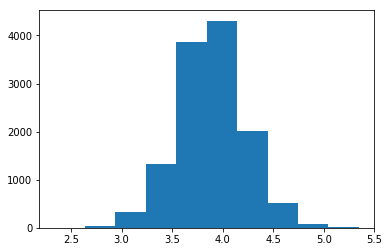

In [149]:
plt.hist(beer_test['pred_overall'])

In [ ]:
pd.sort()

In [250]:
predict(beer,results_overall,'pred_taste')

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

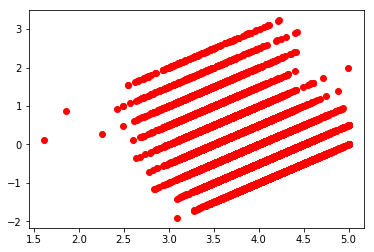

In [251]:
resid = beer['pred_taste'] -  beer['review/taste']

#plt.plot(beer['review/overall'],resid,'ro')
plt.plot(beer['pred_taste'],resid,'ro')

In [248]:
np.mean(resid)

-9.666790433261105e-05

In [223]:
beer.to_csv('beerData.csv',index=False)

In [222]:
beer

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,...,65-80,over 80,popularBrewery,popularxLength,popularxAle,popularxLager,popularxPaleAle,popularxPilsner,popularxStout,pred_overall
0,40163,5.00,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,...,0,0,1.0,94.0,0.0,0.0,0.0,0.0,0.0,3.435032
1,8135,11.00,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,...,0,0,1.0,103.0,0.0,0.0,0.0,0.0,0.0,3.766153
2,10529,4.70,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,...,0,0,1.0,67.0,0.0,0.0,1.0,0.0,0.0,3.809387
3,44610,4.40,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,...,0,0,1.0,69.0,0.0,0.0,0.0,1.0,0.0,3.943457
4,37062,4.40,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,...,0,0,1.0,95.0,0.0,0.0,1.0,0.0,0.0,3.929675
5,14095,10.00,21436,14,YouEnjoyMyStout,Russian Imperial Stout,4.0,4.0,4.0,4.0,...,0,0,1.0,155.0,0.0,0.0,0.0,0.0,1.0,4.022849
6,13759,12.60,10001,14,Benevolence,American Wild Ale,4.0,4.5,4.0,4.0,...,0,0,1.0,124.0,1.0,0.0,0.0,0.0,0.0,3.902640
7,3914,8.40,52211,14879,Frog's Hollow Double Pumpkin Ale,Pumpkin Ale,4.0,4.0,4.0,4.0,...,0,0,1.0,247.0,1.0,0.0,0.0,0.0,0.0,4.179602
8,47953,9.00,34361,394,Stoudt's Barrel Aged Old Abominable,English Barleywine,4.5,4.0,4.5,4.5,...,0,0,1.0,269.0,0.0,0.0,0.0,0.0,0.0,3.702334
9,7047,6.20,32676,1386,One Hop Wonder IPA,American IPA,2.0,2.0,2.0,2.5,...,0,0,1.0,121.0,0.0,0.0,0.0,0.0,0.0,3.218998
